In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('paper')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as MAIN_OUTPUT_DIRECTORY
OUTPUT_DIRECTORY = os.path.join(MAIN_OUTPUT_DIRECTORY, 'ptm-response')

if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

In [3]:
from snapanalysis.models.ptm_response.main import OUTPUT_FILE as PTM_RESPONSE_FILE

from snapanalysis.models.ptm_response.main import PREDICTOR_ORDER
predictors = PREDICTOR_ORDER

limma_results = pd.read_hdf(PTM_RESPONSE_FILE, '/ptm_stats/joint_limma_stats')
predictors_from_limma = limma_results.reset_index()['predictor'].unique()
assert all(p in predictors_from_limma for p in predictors)
assert all(p in predictors for p in predictors_from_limma)

long_matrices = {}
informative_pds = {}


with pd.HDFStore(PTM_RESPONSE_FILE, 'r') as store: 
    enrichment_complexes = store['/ptm_stats/joint_camera_complexes']
    
    for predictor in predictors:
        long_matrices[predictor] = lm = store[f'/ptm_stats/{predictor}/long_matrix']
        informative_pds[predictor] = sorted(lm['Pull-Down ID'].unique())
            

In [4]:
from snapanalysis.models.network.drawall import OUTPUT_HDF_FILE as NETWORK_OUTPUT_FILE

node_meta = pd.read_hdf(NETWORK_OUTPUT_FILE, '/output/node_meta')
community_colors = pd.read_hdf(NETWORK_OUTPUT_FILE, '/output/communities/0.001/colors')
pos_df = node_meta[['network_pos_x', 'network_pos_y']]

In [5]:
pos_df = pos_df.dropna()

In [6]:
def get_values(predictors, col='logFC',
               fill=0.0):
    series = limma_results.loc[predictors, col]
    series = series.reindex(pos_df.index)
    if fill is not False:
        series =  series.fillna(fill)
    return series

In [7]:
import palettable

CMAP = palettable.cmocean.diverging.Balance_19.mpl_colormap

In [8]:
ORDER = [
     # Row 1
     
     'H3K4me1',
     'H3K4me3',
     'H3K9acK14ac',
     'H3K27ac',
     'H2A.Z',
     
     
     # Row 2
     'H4K20me2',
     'H3ac',
     'H4ac',
     'H4K16ac',
     'DNA Methylation',
        
     # Row 3
     'H4K20me3',
     'H3K9me2',
     'H3K9me3',
     'H3K27me2',
     'H3K27me3',

]

In [9]:
all_scores = []
for predictor in predictors:
    values = get_values(predictor, fill=False).dropna()
    all_scores.append(values.dropna())

all_scores = np.concatenate(all_scores)

absmax = np.percentile(np.abs(all_scores), 99)
print(absmax)

2.0456283910279893


100%|██████████| 15/15 [00:00<00:00, 41.01it/s]


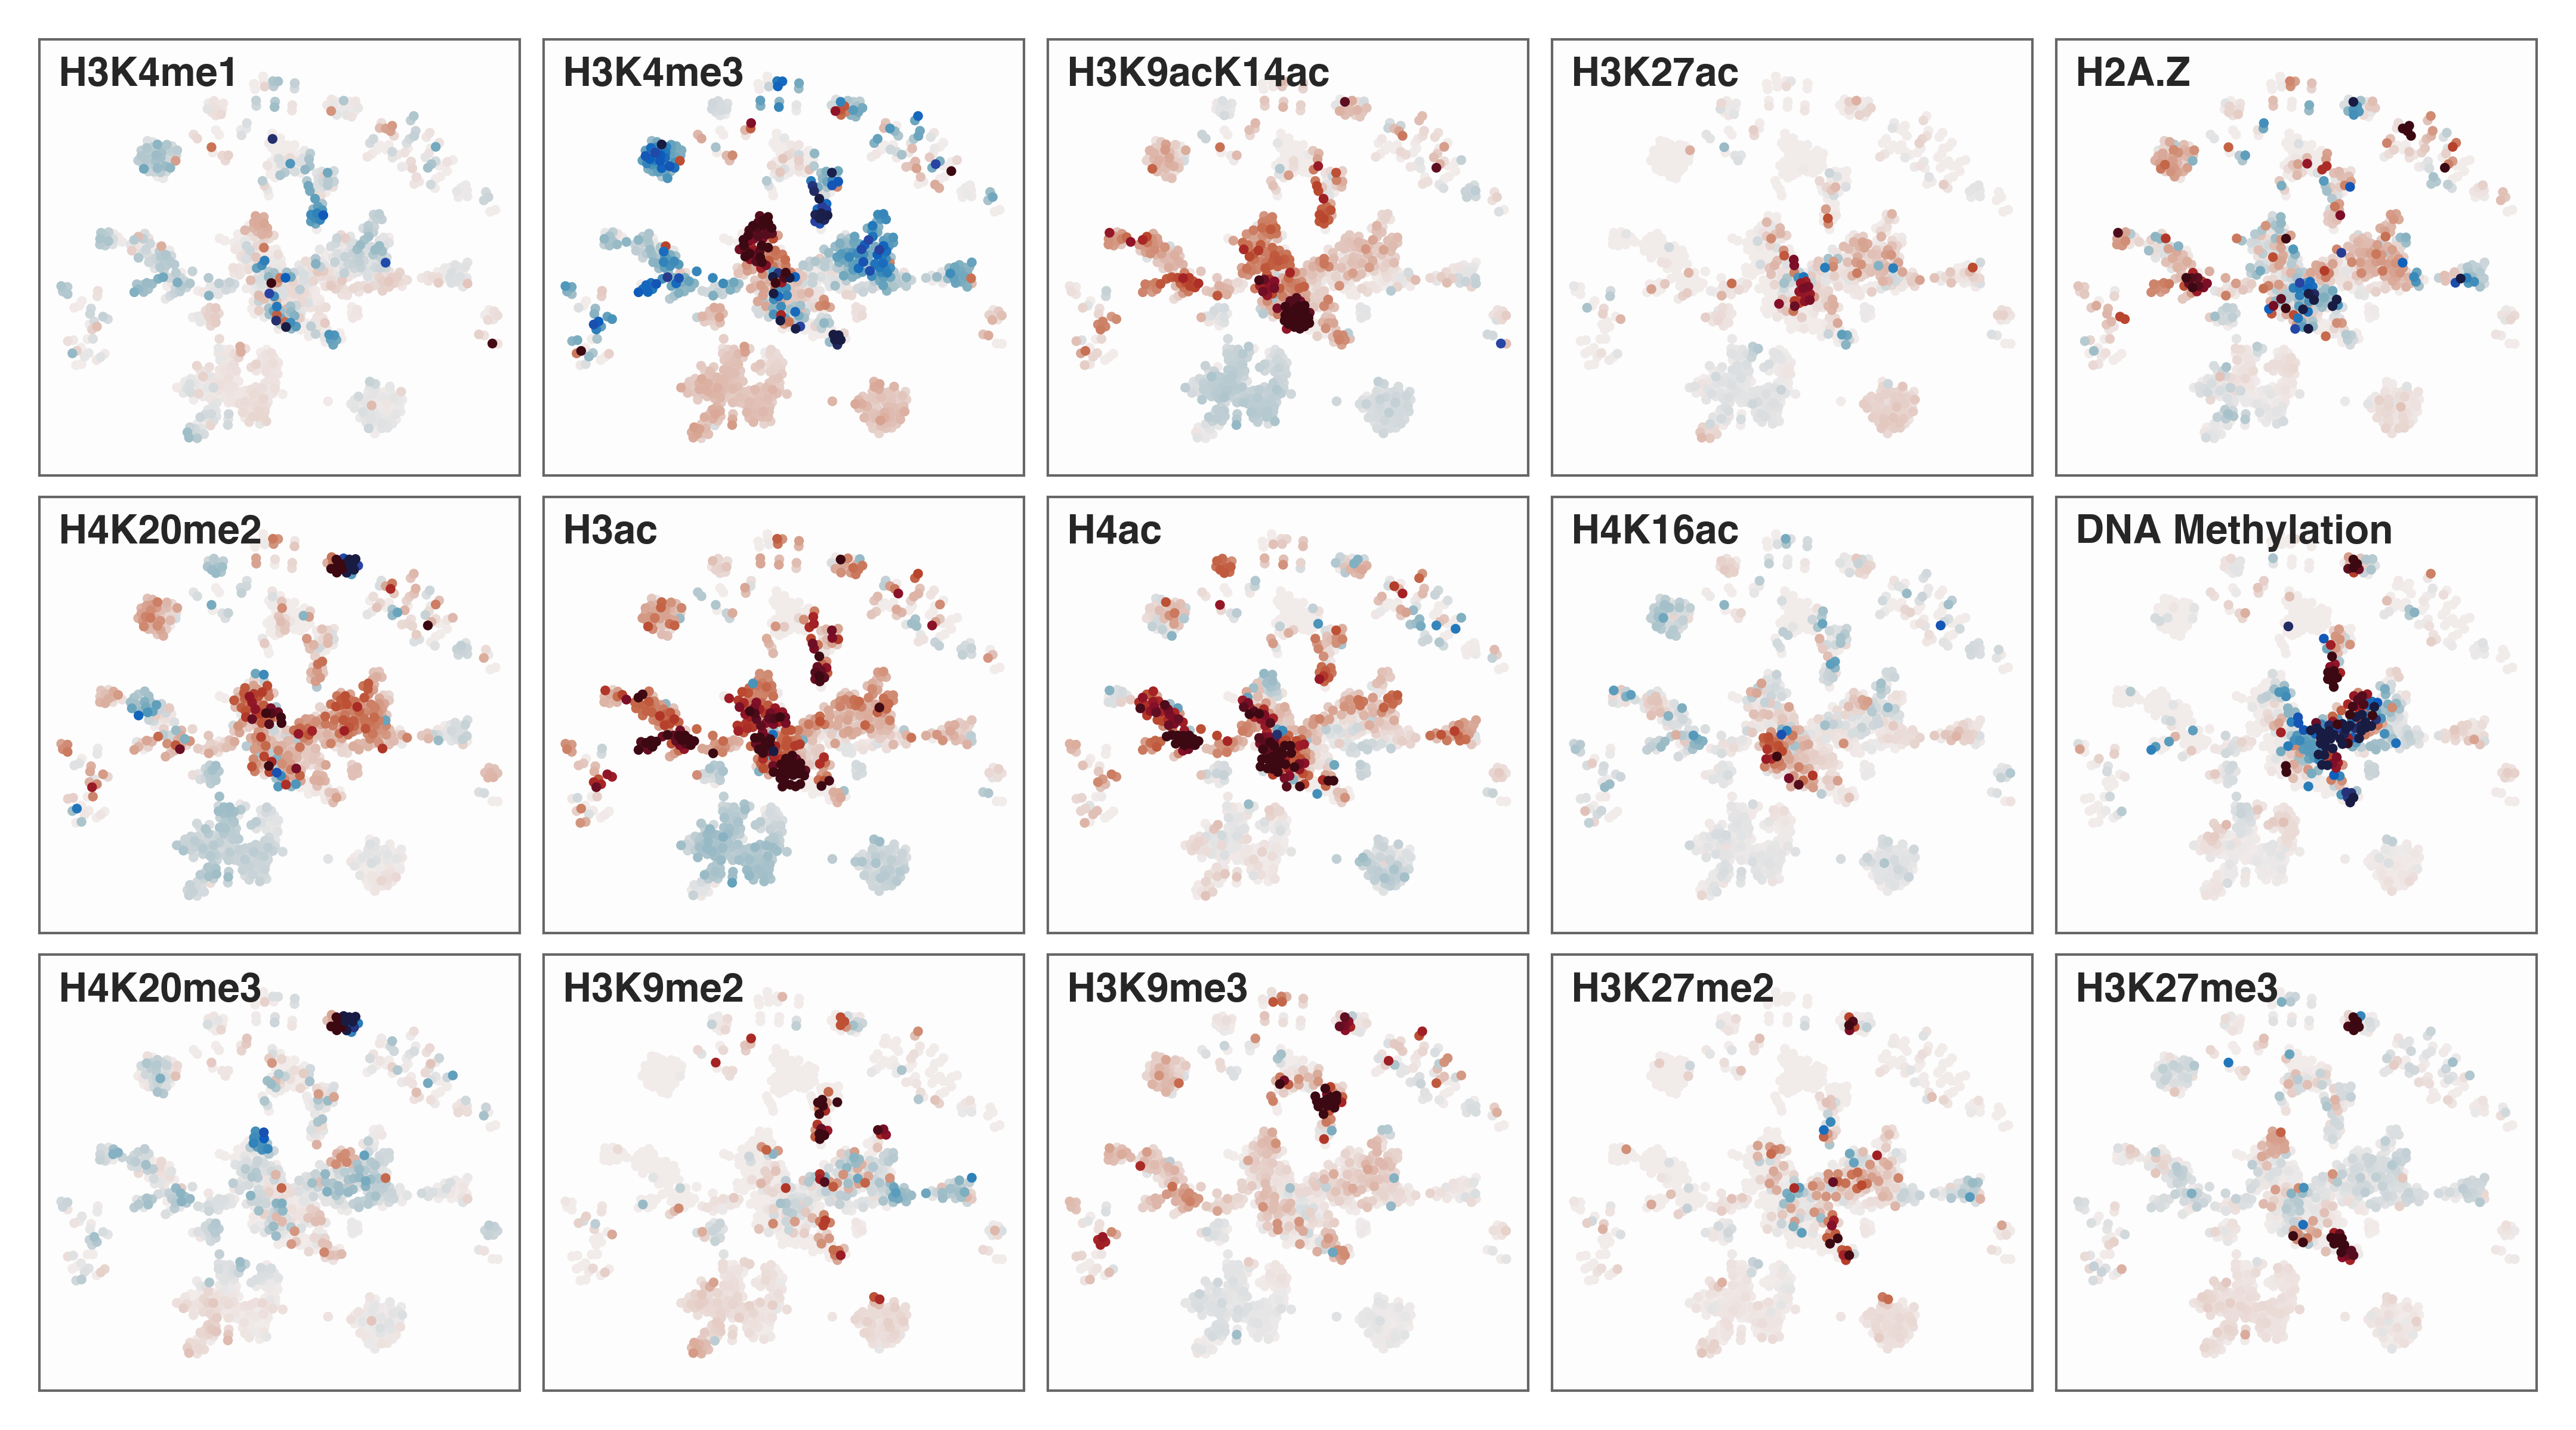

In [10]:
import matplotlib.ticker
import matplotlib.colorbar
import matplotlib.colors

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

FIGSIZE = 9, 5
DPI = 300

N_COLS = 5
N_ROWS = 3

lim_padding = 1.02
scatter_size = 3

VMAX = 1.5
VMIN = -VMAX

BACKGROUND_COLOR = '#FDFDFD'
BORDER_COLOR = '#666666'

figure = plt.figure(figsize=FIGSIZE, dpi=DPI)

# -- Empty square in top-left --- 
# ax = figure.add_subplot(N_ROWS, N_COLS, 1)
# ax.set_visible(False)


# # Axes for colorbar
# cax = inset_axes(ax,
#                  width="100%",
#                  height="100%",
# #                  bbox_to_anchor=(0, .85, 1, 0.05),
#                  bbox_to_anchor=(0.05, .9, 0.6, 0.05),
#                  bbox_transform=ax.transAxes,
#                  loc="upper center", borderpad=0)


# -- Response plots -- 
for i, predictor in enumerate(tqdm(ORDER), start=1):
    
    ax = figure.add_subplot(N_ROWS, N_COLS, i)
    ax.set_facecolor(BACKGROUND_COLOR)
    
    values = get_values(predictor)
    # This should plot highest values on top
    values_abs = values.abs()
    sort_order = values_abs.sort_values().index
    
    pos = node_meta.loc[sort_order, ['network_pos_x', 'network_pos_y']]
    values = values.loc[sort_order]
    
    pos_min = pos.min().min()
    pos_max = pos.max().max()

    norm = matplotlib.colors.Normalize(vmin=VMIN, vmax=VMAX)

    scatter = ax.scatter(pos['network_pos_x'], pos['network_pos_y'], 
                         c=values, 
                         s=scatter_size,
                         alpha=1.0,
                         cmap=CMAP, 
                         norm=norm, 
                         rasterized=True)
    
#     ax.set_xlim(pos_min*lim_padding, pos_max*lim_padding)
#     ax.set_ylim(pos_min*lim_padding, pos_max*lim_padding)

#     ax.set_title(f'{factor}', fontsize=6)
#     ax.set_title(predictor, fontsize=8)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.text(0.04, 0.96, 
            predictor, 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=8,
            fontweight='bold',
            transform=ax.transAxes)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color(BORDER_COLOR)
        spine.set_linewidth(0.5)
#     ax.spines['right'].set_visible(True)
#     ax.spines['top'].set_visible(True)
    ax.set_aspect('equal', 'datalim')

#     break
    
# colorbar = figure.colorbar(scatter, cax=cax, 
#                            orientation='horizontal')
# colorbar.set_ticks([VMIN, 0, VMAX])
# colorbar.set_ticklabels([f'≤ {VMIN}', '|', f'≥ +{VMAX}'])
# colorbar.ax.tick_params(length=0, labelsize=7)

# # colorbar.ax.set_title(' ', 
# #                       va='bottom', 
# #                       loc='left',
# #                       ha='left', fontsize=8)

# colorbar.ax.set_xlabel('Effect to log$_2$ ratio', fontsize=8)

# for i, label in enumerate(colorbar.ax.xaxis.get_majorticklabels()):
#     ha = {0: 'left', 1: 'center', 2: 'right'}[i]
#     label.set_horizontalalignment(ha)
   
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'network-projections.pdf'), bbox_inches='tight')